In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# reading in full dataset
slurm = pd.read_csv("/mnt/scratch/tairaeli/cmse_dat/slurm_cleaned_final.csv",
                         delimiter=",")
slurm = slurm.drop(columns=["Unnamed: 0"])
slurm.head()

/tmp/ipykernel_49876/3955000221.py:2: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  slurm = pd.read_csv("/mnt/scratch/tairaeli/cmse_dat/slurm_cleaned_final.csv",


,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,AssocID,...,CPUTimeRAW,ReqCPUS,AllocCPUS,ReqMem,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES
0,31496544,user_679,group_121,2023-03-21T11:13:45,Unknown,Unknown,00:00:00,PENDING,account_017,assocID_489,...,0,28,0,21000M,NaN,1,1,None assigned,"billing=3192,cpu=28,gres/gpu=4,mem=21000M,node=1",NaN
1,31497932,user_679,group_121,2023-03-21T11:31:18,Unknown,Unknown,00:00:00,PENDING,account_017,assocID_489,...,0,28,0,21000M,NaN,1,1,None assigned,"billing=3192,cpu=28,gres/gpu=4,mem=21000M,node=1",NaN
2,31993628,user_105,group_114,2023-03-22T18:19:12,Unknown,Unknown,00:00:00,PENDING,account_017,assocID_661,...,0,12,0,150G,NaN,1,1,None assigned,"billing=23347,cpu=12,gres/gpu=8,mem=150G,node=1",NaN
3,39087660,user_652,group_054,2023-04-04T13:09:10,Unknown,Unknown,00:00:00,PENDING,account_017,assocID_557,...,0,640,0,20G,NaN,10,10,None assigned,"billing=3112,cpu=640,mem=20G,node=10",NaN
4,59062820,user_188,group_046,2023-05-08T09:58:20,2024-01-01T00:58:57,2024-01-01T00:59:06,00:00:09,COMPLETED,account_017,assocID_676,...,360,40,40,8G,NaN,1,1,skl-029,"billing=1245,cpu=40,mem=8G,node=1","billing=1245,cpu=40,mem=8G,node=1"


In [3]:
# defining some functions
def CalculateUtilization(data):
    """
    Runs through each requested resource (time, CPU, nodes, memory) and determines the fraction of
    requested resources that they actually used

    Parameters:
    :param data: DataFrame with SLURM job records.
    
    Returns:
    DataFrame with columns for 'User', 'JobID', 'Group', 'State', 'Account', and utilization fractions.
    """
    
    # Calculate underutilized resources
    data['UtilizeCPUFrac'] = data.ReqCPUS/data.AllocCPUS    
    data['UtilizeNodesFrac'] = data.ReqNodes/data.NNodes  
    data['UtilizeTimeFrac'] = data['Elapsed'] / data['Timelimit']   
    data['UtilizeMemoryFrac'] = data['MaxRSS_MB'] / data['ReqMem_MB']
    
    return data[['User', 'JobID', 'Group', 'State', 'Account', 
                          'Timelimit', 'UtilizeTimeFrac', 
                          'ReqCPUS','UtilizeCPUFrac','ReqNodes', 
                          'UtilizeNodesFrac', 'ReqMem_MB', 
                          'UtilizeMemoryFrac']]


def parse_time_string(time_str):
    """Convert a time string into a hours."""
    days = 0

    if type(time_str) == float:
        return 0.0

    if '-' in time_str:
        days, time_str = time_str.split('-')
        days = int(days)

    parts = time_str.split(':')
    hours, minutes, seconds = map(int, parts) if len(parts) == 3 else (int(parts[0]), int(parts[1]), 0)
    
    # got this from https://stackoverflow.com/questions/62103547/how-to-convert-timedelta-to-hours
    hrs = hours + days*24 + minutes/60 + seconds/3600
    
    return hrs

# # convert ReqMem to a uniform measurement (assuming 'M' for MB and 'G' for GB and 'K' for KB)
def convert_memory(mem_str):
    '''
    Convert memory units to MegaBytes unit float.
    '''
    if type(mem_str)==float:
        return np.nan
    if mem_str.endswith('M'):
        return float(mem_str[:-1]) # remove 'M' and convert to float
    elif mem_str.endswith('K'):
        return float(mem_str[:-1]) / 1000
    elif mem_str.endswith('G'):
        return float(mem_str[:-1]) * 1e3  # convert MB to KB
    elif mem_str.endswith('T'):
        return float(mem_str[:-1]) * 1e6 # convert MB to T

In [4]:
# doing some cleaning on the data
slurm['Timelimit'] = slurm['Timelimit'].apply(parse_time_string)
slurm['Elapsed'] = slurm['Elapsed'].apply(parse_time_string)
slurm["MaxRSS_MB"] = slurm["MaxRSS"].apply(convert_memory)
slurm["ReqMem_MB"] = slurm["ReqMem"].apply(convert_memory)

In [5]:
# function to find underutilizers
underutilizers = CalculateUtilization(slurm)
underutilizers.dropna().head(10)

,User,JobID,Group,State,Account,Timelimit,UtilizeTimeFrac,ReqCPUS,UtilizeCPUFrac,ReqNodes,UtilizeNodesFrac,ReqMem_MB,UtilizeMemoryFrac
201,user_600,87461884,group_090,COMPLETED,account_011,36.0,0.894684,64,1.0,4,1.0,32000.0,0.000141
202,user_600,87461892,group_090,COMPLETED,account_011,36.0,0.834784,64,1.0,4,1.0,32000.0,0.000142
203,user_600,87461900,group_090,COMPLETED,account_011,36.0,0.817600,64,1.0,4,1.0,32000.0,0.000142
204,user_600,87461908,group_090,COMPLETED,account_011,36.0,0.837546,64,1.0,4,1.0,32000.0,0.000142
205,user_600,87461916,group_090,COMPLETED,account_011,36.0,0.841073,64,1.0,4,1.0,32000.0,0.000144
206,user_600,87461924,group_090,COMPLETED,account_011,36.0,0.834954,64,1.0,4,1.0,32000.0,0.000142
207,user_600,87461932,group_090,COMPLETED,account_011,36.0,0.848549,64,1.0,4,1.0,32000.0,0.000142
208,user_600,87461940,group_090,COMPLETED,account_011,36.0,0.826273,64,1.0,4,1.0,32000.0,0.000142
209,user_600,87461948,group_090,TIMEOUT,account_011,36.0,1.000255,64,1.0,4,1.0,32000.0,0.000142
210,user_600,87461956,group_090,COMPLETED,account_011,36.0,0.780301,64,1.0,4,1.0,32000.0,0.000141


With this data, the first thing I decided to do was create a histogram of my data. Since histogram binning can be quite misleading on occasion, I decided to use a kernel density estimator to assist my plot

<Axes: xlabel='UtilizeTimeFrac', ylabel='Count'>

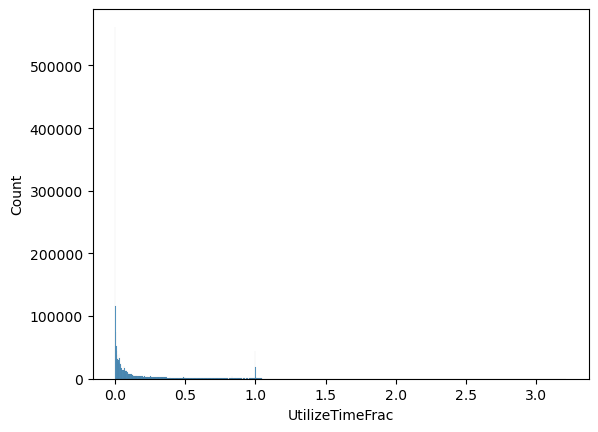

In [6]:
sns.histplot(underutilizers.UtilizeTimeFrac)

<Axes: xlabel='Elapsed', ylabel='Density'>

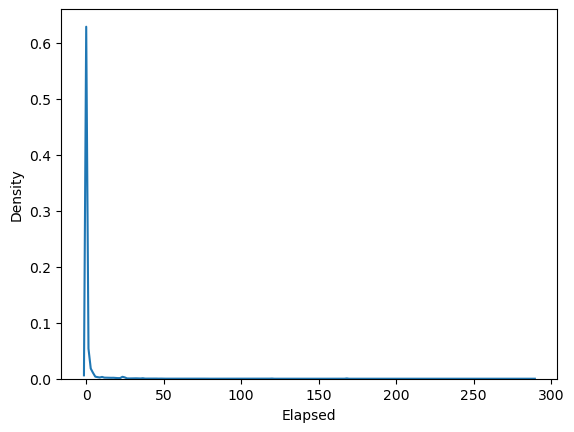

In [7]:
sns.kdeplot(slurm['Elapsed'])

Needless to say, I did not get what I was looking for. It seems as though there were a few jobs that actually overutilized, in which the HPCC used more resources than requested and made this plot look like garbage. Thus I decided to try simply removing all of the negative data and investigate it separately.

This doesn't help a bunch, but it's still pretty interesting, although I do want to try to add to this visual to make it more visually interesting.

Here's the same visual for the overutilizer data

In [9]:
overutilizer = underutilizers[underutilizers["UtilizeTimeFrac"] > 1.3]
overutilizer.head()

,User,JobID,Group,State,Account,Timelimit,UtilizeTimeFrac,ReqCPUS,UtilizeCPUFrac,ReqNodes,UtilizeNodesFrac,ReqMem_MB,UtilizeMemoryFrac
3265,user_258,91603432,group_010,COMPLETED,account_025,0.0,inf,123,1.0,1,1.0,NaN,NaN
3266,user_258,91603432,group_010,COMPLETED,account_025,0.0,inf,123,1.0,1,1.0,NaN,NaN
3269,user_258,91603452,group_010,COMPLETED,account_025,0.0,inf,1,1.0,1,1.0,NaN,NaN
3270,user_258,91603452,group_010,COMPLETED,account_025,0.0,inf,1,1.0,1,1.0,NaN,NaN
3274,user_258,91603468,group_010,COMPLETED,account_025,0.0,inf,123,1.0,1,1.0,NaN,NaN


Same as above. Kind of interesting, but I think there's a lot of room for me to improve here

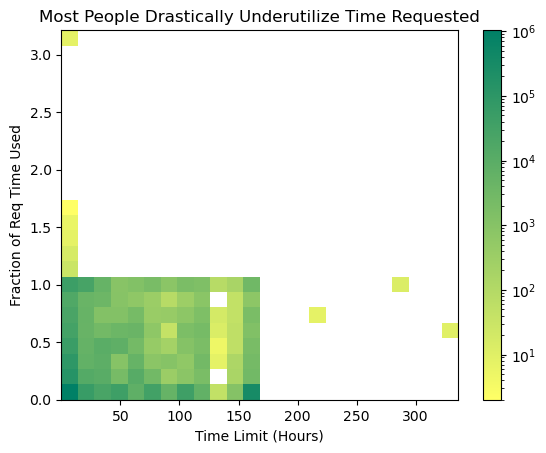

In [15]:
import matplotlib as mpl

temp_df = underutilizers.dropna(subset="UtilizeTimeFrac")
temp_df = temp_df[temp_df["UtilizeTimeFrac"] != np.inf]

plt.hist2d(temp_df["Timelimit"], temp_df["UtilizeTimeFrac"], 
           bins=(24,24), norm=mpl.colors.LogNorm(), cmap=mpl.cm.summer_r)
plt.xlabel("Time Limit (Hours)")
plt.ylabel("Fraction of Req Time Used")
plt.title("Most People Drastically Underutilize Time Requested")
plt.colorbar()

A few people using more resources than requested.Removing them to see more information on the range from 0-1

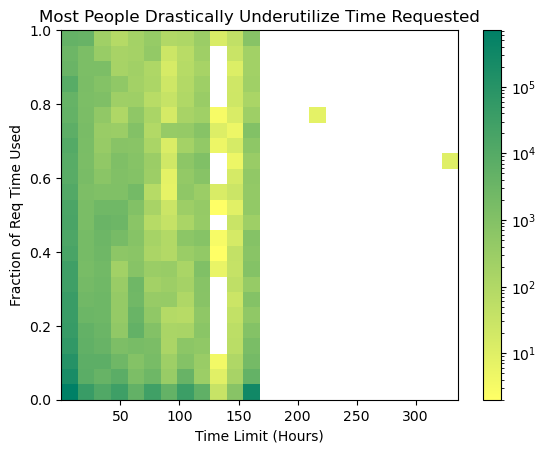

In [16]:
# cutting out overtulilizers 
temp_df = temp_df[temp_df["UtilizeTimeFrac"] <=1]

plt.hist2d(temp_df["Timelimit"], temp_df["UtilizeTimeFrac"], bins=(24,24),
           norm=mpl.colors.LogNorm(), cmap=mpl.cm.summer_r)
plt.xlabel("Time Limit (Hours)")
plt.ylabel("Fraction of Req Time Used")
plt.title("Most People Drastically Underutilize Time Requested")
plt.colorbar()
plt.savefig("hist_2d_time_req.png")

Zooming in onto the time requested within first 24 hours

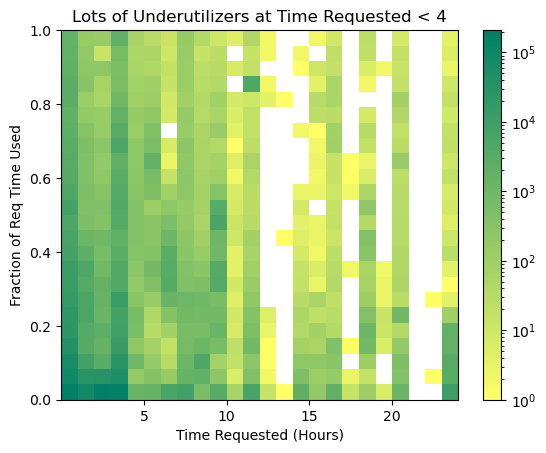

In [17]:
f24 = temp_df[temp_df["Timelimit"] < 24]

plt.hist2d(f24["Timelimit"], f24["UtilizeTimeFrac"], bins=(24,24),
           norm=mpl.colors.LogNorm(), cmap=mpl.cm.summer_r)
plt.xlabel("Time Requested (Hours)")
plt.ylabel("Fraction of Req Time Used")
plt.title("Lots of Underutilizers at Time Requested < 4")
plt.colorbar()
plt.savefig("hist_2d_time_req_first24.png")

Making another 2D hist for Memory Underutilized

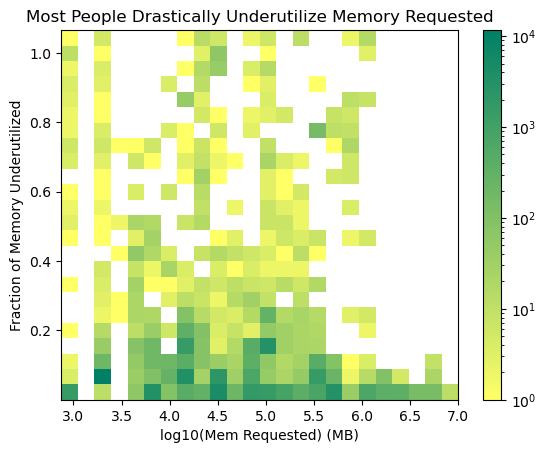

In [14]:
underutilizers_no_na = underutilizers.dropna()

temp_df = underutilizers_no_na[underutilizers_no_na["UtilizeMemoryFrac"] < 1.1]

plt.hist2d(np.log10(temp_df["ReqMem_MB"]), temp_df["UtilizeMemoryFrac"],
           bins=(24,24), norm=mpl.colors.LogNorm(), cmap=mpl.cm.summer_r)
plt.xlabel("log10(Mem Requested) (MB)")
plt.ylabel("Fraction of Memory Underutilized")
plt.title("Most People Drastically Underutilize Memory Requested")
plt.colorbar()